# Employee Turnover Prediction (Stay vs Leave)

This Colab notebook follows your requested workflow.

**Final Exports**
- `Employee_Turnover_Predictions.csv`
- `Employee_Turnover_Output.xlsx` (3 sheets)
  - `1_Employee Turnover Prediction`
  - `2_Expected Model Outcomes`
  - `3_Success Criteria`
- `employee_turnover_model_pipeline.joblib`

Run the notebook top-to-bottom. You’ll be asked to upload a CSV/XLSX file.


In [1]:

# ============================================================
# Colab Notebook: Employee Turnover Prediction (Stay vs Leave)
# ============================================================
# Optional: If you want SHAP explanations, install shap:
# !pip -q install shap

import os
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from pandas import ExcelWriter

print("Imports loaded successfully.")


Imports loaded successfully.


In [2]:

# =========================================
# STEP 0: Upload dataset (CSV or Excel)
# =========================================
from google.colab import files

print("Upload your dataset file (CSV or XLSX).")
uploaded = files.upload()

uploaded_filenames = list(uploaded.keys())
if len(uploaded_filenames) == 0:
    raise ValueError("No file uploaded. Please upload a CSV or Excel file.")

file_name = uploaded_filenames[0]
print("Uploaded file:", file_name)

if file_name.lower().endswith(".csv"):
    df = pd.read_csv(file_name)
elif file_name.lower().endswith((".xlsx", ".xls")):
    df = pd.read_excel(file_name)
else:
    raise ValueError("Unsupported file format. Upload .csv or .xlsx/.xls")

print("Data loaded. Shape:", df.shape)
df.head()


Upload your dataset file (CSV or XLSX).


Saving modified_employee_turnover.csv to modified_employee_turnover.csv
Uploaded file: modified_employee_turnover.csv
Data loaded. Shape: (1350, 16)


,Job_Satisfaction,Performance_Rating,Years_At_Company,Work_Life_Balance,Distance_From_Home,Monthly_Income,Education_Level,Age,Num_Companies_Worked,Employee_Role,Annual_Bonus,Training_Hours,Department,Annual_Bonus_Squared,Annual_Bonus_Training_Hours_Interaction,Employee_Turnover
0,0.562326,0.141129,0.123989,0.347583,0.330353,0.328853,0.600933,0.315990,0.768736,0.090671,0.324786,0.669193,0.602932,0.105486,0.217344,0
1,0.017041,0.559047,0.511203,0.793908,0.423550,0.553450,0.742009,0.897146,0.380035,0.601633,0.694611,0.043271,0.800761,0.482484,0.030056,0
2,0.774699,0.604371,0.798174,0.260500,0.804034,0.131800,0.775178,0.830947,0.218726,0.972936,0.153476,0.701336,0.705275,0.023555,0.107638,1
3,0.628174,0.385249,0.230104,0.516809,0.272248,0.589249,0.482409,0.090507,0.402746,0.132842,0.305973,0.549688,0.600531,0.093620,0.168190,0
4,0.799183,0.199967,0.839029,0.247927,0.341934,0.076818,0.055356,0.680860,0.923341,0.493017,0.844094,0.793751,0.664679,0.712494,0.670000,0


In [3]:

# =========================================
# STEP 0.1: Standardize column names
# =========================================
def standardize_columns(cols):
    new_cols = []
    for c in cols:
        c2 = str(c).strip()
        c2 = re.sub(r"[^\w]+", "_", c2)
        c2 = re.sub(r"_+", "_", c2)
        c2 = c2.strip("_")
        new_cols.append(c2)
    return new_cols

df.columns = standardize_columns(df.columns)

print("Standardized Columns:")
print(df.columns.tolist())


Standardized Columns:
['Job_Satisfaction', 'Performance_Rating', 'Years_At_Company', 'Work_Life_Balance', 'Distance_From_Home', 'Monthly_Income', 'Education_Level', 'Age', 'Num_Companies_Worked', 'Employee_Role', 'Annual_Bonus', 'Training_Hours', 'Department', 'Annual_Bonus_Squared', 'Annual_Bonus_Training_Hours_Interaction', 'Employee_Turnover']


In [4]:

# ======================================================
# STEP 1: Identify Target Column (Turnover / Attrition)
# ======================================================
candidate_targets = [
    "Attrition", "EmployeeTurnover", "Turnover", "Left", "Leave",
    "Employee_Attrition", "Employee_Turnover", "Churn", "Resigned"
]

target_col = None
for c in df.columns:
    if c.lower() in [x.lower() for x in candidate_targets]:
        target_col = c
        break

if target_col is None:
    for c in df.columns:
        cl = c.lower()
        if ("attrit" in cl) or ("turnover" in cl) or (cl in ["target", "label", "y"]) or (cl == "leave"):
            target_col = c
            break

print("Detected target column:", target_col)

if target_col is None:
    print("Target column not auto-detected.")
    print("Available columns:")
    print(df.columns.tolist())
    raise ValueError("Please rename your target column to something like 'Attrition' or 'EmployeeTurnover' (0/1 or Stay/Leave).")

data = df.copy()

def normalize_target(s):
    if s.dtype == "O":
        s2 = s.astype(str).str.strip().str.lower()
        leave_set = set(["1", "yes", "y", "true", "leave", "left", "resigned", "attrition", "terminated"])
        stay_set  = set(["0", "no", "n", "false", "stay", "stayed", "active", "retain", "retained"])
        mapped = []
        for v in s2:
            if v in leave_set:
                mapped.append(1)
            elif v in stay_set:
                mapped.append(0)
            else:
                mapped.append(np.nan)
        return pd.Series(mapped, index=s.index)
    else:
        return s.astype(float)

data[target_col] = normalize_target(data[target_col])

if data[target_col].isna().any():
    bad_count = int(data[target_col].isna().sum())
    print(f"Found {bad_count} rows with unrecognized target labels. Dropping those rows.")
    data = data.dropna(subset=[target_col]).copy()

data[target_col] = data[target_col].astype(int)

print("Target distribution:")
print(data[target_col].value_counts(dropna=False))


Detected target column: Employee_Turnover
Target distribution:
Employee_Turnover
0    678
1    672
Name: count, dtype: int64


Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Job_Satisfaction                         1350 non-null   float64
 1   Performance_Rating                       1350 non-null   float64
 2   Years_At_Company                         1350 non-null   float64
 3   Work_Life_Balance                        1350 non-null   float64
 4   Distance_From_Home                       1350 non-null   float64
 5   Monthly_Income                           1350 non-null   float64
 6   Education_Level                          1350 non-null   float64
 7   Age                                      1350 non-null   float64
 8   Num_Companies_Worked                     1350 non-null   float64
 9   Employee_Role                            1350 non-null   float64
 10  Annual_Bonus                        

None

Summary (numeric):


,count,mean,std,min,25%,50%,75%,max
Job_Satisfaction,1350.0,0.506386,0.291505,1.737827e-03,0.263051,0.525340,0.750987,0.998692
Performance_Rating,1350.0,0.487061,0.283808,5.459650e-04,0.238538,0.468457,0.724088,0.999957
Years_At_Company,1350.0,0.484761,0.282758,1.545250e-03,0.249651,0.485414,0.721622,0.999722
Work_Life_Balance,1350.0,0.499442,0.293013,1.664410e-04,0.246399,0.495572,0.753108,0.999931
Distance_From_Home,1350.0,0.494884,0.289248,1.319025e-03,0.244162,0.501617,0.743938,0.997813
Monthly_Income,1350.0,0.509909,0.290110,5.015471e-03,0.263235,0.532388,0.761090,0.999143
Education_Level,1350.0,0.504329,0.295693,4.235700e-04,0.249894,0.509448,0.755113,0.999794
Age,1350.0,0.500164,0.294835,2.305850e-04,0.239224,0.499964,0.767168,0.998365
Num_Companies_Worked,1350.0,0.516149,0.295072,1.503810e-04,0.247978,0.531408,0.775888,0.999962
Employee_Role,1350.0,0.506091,0.284901,9.032860e-04,0.269517,0.504640,0.761640,0.999964


Attrition Rate (Leave=1): 0.498 (49.8%)


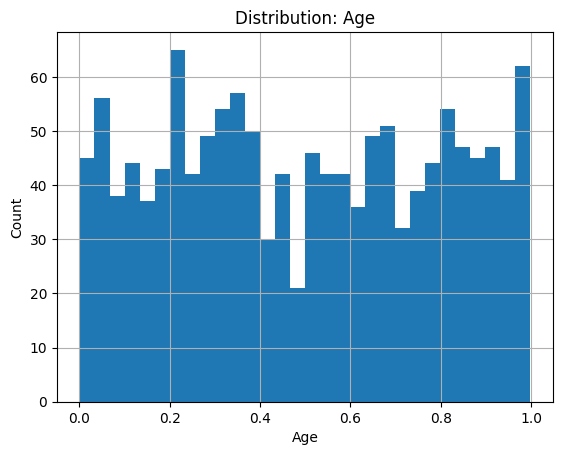

Leave-rate by Department:


,Employee_Turnover
Department,
0.999386,1.0
0.992645,1.0
0.966738,1.0
0.965493,1.0
0.963302,1.0
0.961633,1.0
0.956675,1.0
0.956123,1.0
0.044553,1.0


Correlation with target (numeric only):


,Employee_Turnover
Employee_Turnover,1.000000
Job_Satisfaction,0.357116
Distance_From_Home,0.350905
Performance_Rating,0.340058
Work_Life_Balance,0.298103
Years_At_Company,0.296231
Employee_Role,0.064028
Annual_Bonus_Squared,0.029532
Age,0.024104
Annual_Bonus,0.018733


In [5]:

# ======================================================
# STEP 1A: EDA (Exploratory Data Analysis)
# ======================================================
print("Basic info:")
display(data.info())

print("Summary (numeric):")
display(data.describe().T)

attrition_rate = data[target_col].mean()
print(f"Attrition Rate (Leave=1): {attrition_rate:.3f} ({attrition_rate*100:.1f}%)")

key_fields = ["Age", "MonthlyIncome", "YearsAtCompany", "DistanceFromHome"]
existing_key_fields = [c for c in key_fields if c in data.columns]

if existing_key_fields:
    for col in existing_key_fields:
        plt.figure()
        data[col].hist(bins=30)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

group_cols = ["Department", "EmployeeRole", "WorkLifeBalance", "JobSatisfaction"]
existing_group_cols = [c for c in group_cols if c in data.columns]

for gc in existing_group_cols:
    grp = data.groupby(gc)[target_col].mean().sort_values(ascending=False)
    print(f"Leave-rate by {gc}:")
    display(grp.head(20))

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = data[num_cols].corr(numeric_only=True)[target_col].sort_values(ascending=False)
    print("Correlation with target (numeric only):")
    display(corr)

    strong_corr = corr[abs(corr) > 0.95].index.tolist()
    if len(strong_corr) > 1:
        print("Possible leakage columns (very high correlation):", strong_corr)


In [6]:

# ======================================================
# STEP 1B: Data Cleaning
# ======================================================
cleaned = data.copy()

before = cleaned.shape[0]
cleaned = cleaned.drop_duplicates()
after = cleaned.shape[0]
print(f"Duplicates removed: {before - after}")

possible_non_negative = ["Age", "MonthlyIncome", "YearsAtCompany", "DistanceFromHome", "AnnualBonus", "Traininghours", "Training_hours"]
for col in possible_non_negative:
    if col in cleaned.columns and pd.api.types.is_numeric_dtype(cleaned[col]):
        neg_count = int((cleaned[col] < 0).sum())
        if neg_count > 0:
            print(f"Found {neg_count} negative values in {col}. Setting to NaN (will be imputed).")
            cleaned.loc[cleaned[col] < 0, col] = np.nan

def cap_outliers(series, lower_q=0.01, upper_q=0.99):
    if not pd.api.types.is_numeric_dtype(series):
        return series
    lo = series.quantile(lower_q)
    hi = series.quantile(upper_q)
    return series.clip(lo, hi)

for col in ["MonthlyIncome", "AnnualBonus"]:
    if col in cleaned.columns and pd.api.types.is_numeric_dtype(cleaned[col]):
        cleaned[col] = cap_outliers(cleaned[col], 0.01, 0.99)

print("Cleaning complete. Shape:", cleaned.shape)
cleaned.head()


Duplicates removed: 450
Cleaning complete. Shape: (900, 16)


,Job_Satisfaction,Performance_Rating,Years_At_Company,Work_Life_Balance,Distance_From_Home,Monthly_Income,Education_Level,Age,Num_Companies_Worked,Employee_Role,Annual_Bonus,Training_Hours,Department,Annual_Bonus_Squared,Annual_Bonus_Training_Hours_Interaction,Employee_Turnover
0,0.562326,0.141129,0.123989,0.347583,0.330353,0.328853,0.600933,0.315990,0.768736,0.090671,0.324786,0.669193,0.602932,0.105486,0.217344,0
1,0.017041,0.559047,0.511203,0.793908,0.423550,0.553450,0.742009,0.897146,0.380035,0.601633,0.694611,0.043271,0.800761,0.482484,0.030056,0
2,0.774699,0.604371,0.798174,0.260500,0.804034,0.131800,0.775178,0.830947,0.218726,0.972936,0.153476,0.701336,0.705275,0.023555,0.107638,1
3,0.628174,0.385249,0.230104,0.516809,0.272248,0.589249,0.482409,0.090507,0.402746,0.132842,0.305973,0.549688,0.600531,0.093620,0.168190,0
4,0.799183,0.199967,0.839029,0.247927,0.341934,0.076818,0.055356,0.680860,0.923341,0.493017,0.844094,0.793751,0.664679,0.712494,0.670000,0


In [7]:

# ======================================================
# STEP 1C: Feature Engineering
# ======================================================
fe = cleaned.copy()

if "YearsAtCompany" in fe.columns and pd.api.types.is_numeric_dtype(fe["YearsAtCompany"]):
    fe["TenureBand"] = pd.cut(
        fe["YearsAtCompany"],
        bins=[-np.inf, 1, 3, 5, np.inf],
        labels=["0-1", "1-3", "3-5", "5+"]
    )

if "MonthlyIncome" in fe.columns and pd.api.types.is_numeric_dtype(fe["MonthlyIncome"]):
    try:
        fe["IncomeBand"] = pd.qcut(fe["MonthlyIncome"], q=3, labels=["Low", "Medium", "High"])
    except Exception:
        fe["IncomeBand"] = pd.cut(fe["MonthlyIncome"], bins=3, labels=["Low", "Medium", "High"])

if "DistanceFromHome" in fe.columns and pd.api.types.is_numeric_dtype(fe["DistanceFromHome"]):
    fe["CommuteBand"] = pd.cut(
        fe["DistanceFromHome"],
        bins=[-np.inf, 5, 15, np.inf],
        labels=["Near", "Medium", "Far"]
    )

if "AnnualBonus" in fe.columns and pd.api.types.is_numeric_dtype(fe["AnnualBonus"]):
    if "AnnualBonus_Squared" not in fe.columns:
        fe["AnnualBonus_Squared"] = fe["AnnualBonus"] ** 2

training_candidates = [c for c in fe.columns if c.lower() in ["traininghours", "training_hours", "training", "training_hours_spent"]]
training_col = training_candidates[0] if training_candidates else None

if training_col and "AnnualBonus" in fe.columns:
    if "AnnualBonus_TrainingHours_Interaction" not in fe.columns:
        fe["AnnualBonus_TrainingHours_Interaction"] = fe["AnnualBonus"] * fe[training_col]

if ("JobSatisfaction" in fe.columns) and ("WorkLifeBalance" in fe.columns):
    if pd.api.types.is_numeric_dtype(fe["JobSatisfaction"]) and pd.api.types.is_numeric_dtype(fe["WorkLifeBalance"]):
        fe["Satisfaction_WLB_Interaction"] = fe["JobSatisfaction"] * fe["WorkLifeBalance"]

if ("MonthlyIncome" in fe.columns) and ("YearsAtCompany" in fe.columns):
    if pd.api.types.is_numeric_dtype(fe["MonthlyIncome"]) and pd.api.types.is_numeric_dtype(fe["YearsAtCompany"]):
        fe["Income_Tenure_Interaction"] = fe["MonthlyIncome"] * fe["YearsAtCompany"]

print("Feature Engineering complete. Shape:", fe.shape)
fe.head()


Feature Engineering complete. Shape: (900, 16)


,Job_Satisfaction,Performance_Rating,Years_At_Company,Work_Life_Balance,Distance_From_Home,Monthly_Income,Education_Level,Age,Num_Companies_Worked,Employee_Role,Annual_Bonus,Training_Hours,Department,Annual_Bonus_Squared,Annual_Bonus_Training_Hours_Interaction,Employee_Turnover
0,0.562326,0.141129,0.123989,0.347583,0.330353,0.328853,0.600933,0.315990,0.768736,0.090671,0.324786,0.669193,0.602932,0.105486,0.217344,0
1,0.017041,0.559047,0.511203,0.793908,0.423550,0.553450,0.742009,0.897146,0.380035,0.601633,0.694611,0.043271,0.800761,0.482484,0.030056,0
2,0.774699,0.604371,0.798174,0.260500,0.804034,0.131800,0.775178,0.830947,0.218726,0.972936,0.153476,0.701336,0.705275,0.023555,0.107638,1
3,0.628174,0.385249,0.230104,0.516809,0.272248,0.589249,0.482409,0.090507,0.402746,0.132842,0.305973,0.549688,0.600531,0.093620,0.168190,0
4,0.799183,0.199967,0.839029,0.247927,0.341934,0.076818,0.055356,0.680860,0.923341,0.493017,0.844094,0.793751,0.664679,0.712494,0.670000,0


In [8]:

# ======================================================
# STEP 1D: Train/Test Split (Stratified)
# ======================================================
X = fe.drop(columns=[target_col])
y = fe[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Split complete.")
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train target rate:", y_train.mean(), " Test target rate:", y_test.mean())


Split complete.
Train shape: (720, 15)  Test shape: (180, 15)
Train target rate: 0.49166666666666664  Test target rate: 0.4888888888888889


In [9]:

# ======================================================
# STEP 1E: Preprocessing pipeline
# ======================================================
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

print("Preprocessing pipeline ready.")
print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Preprocessing pipeline ready.
Numeric features: 15
Categorical features: 0


In [10]:

# ======================================================
# STEP 1F: Model Training
# ======================================================
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=300),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

fitted_models = {}
for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    fitted_models[name] = clf
    print("Trained:", name)

print("All baseline models trained.")


Trained: LogisticRegression
Trained: DecisionTree
Trained: RandomForest
Trained: GradientBoosting
All baseline models trained.


In [11]:

# ======================================================
# STEP 1G: Model Evaluation (threshold = 0.5)
# ======================================================
def evaluate_pipeline(pipeline, X_te, y_te, threshold=0.5):
    proba = pipeline.predict_proba(X_te)[:, 1]
    pred = (proba >= threshold).astype(int)

    cm = confusion_matrix(y_te, pred)
    prec = precision_score(y_te, pred, zero_division=0)
    rec  = recall_score(y_te, pred, zero_division=0)
    f1   = f1_score(y_te, pred, zero_division=0)

    roc = roc_auc_score(y_te, proba) if len(np.unique(y_te)) > 1 else np.nan
    pr  = average_precision_score(y_te, proba) if len(np.unique(y_te)) > 1 else np.nan

    return {
        "threshold": threshold,
        "precision_leave": prec,
        "recall_leave": rec,
        "f1_leave": f1,
        "roc_auc": roc,
        "pr_auc": pr,
        "confusion_matrix": cm,
        "proba": proba,
        "pred": pred
    }

results = []
for name, clf in fitted_models.items():
    r = evaluate_pipeline(clf, X_test, y_test, threshold=0.5)
    results.append([name, r["precision_leave"], r["recall_leave"], r["f1_leave"], r["roc_auc"], r["pr_auc"]])

results_df = pd.DataFrame(results, columns=["Model", "Precision(Leave)", "Recall(Leave)", "F1(Leave)", "ROC-AUC", "PR-AUC"])
results_df = results_df.sort_values(by=["F1(Leave)", "Recall(Leave)"], ascending=False)

print("Model comparison (threshold=0.5):")
display(results_df)


Model comparison (threshold=0.5):


,Model,Precision(Leave),Recall(Leave),F1(Leave),ROC-AUC,PR-AUC
0,LogisticRegression,0.882353,0.852273,0.867052,0.958498,0.958811
3,GradientBoosting,0.873418,0.784091,0.826347,0.929471,0.931884
2,RandomForest,0.853659,0.795455,0.823529,0.914402,0.916601
1,DecisionTree,0.746835,0.670455,0.706587,0.726532,0.661830


In [12]:

# ======================================================
# STEP 1H: Hyperparameter Tuning (Random Forest)
# ======================================================
best_model_name = results_df.iloc[0]["Model"]
print("Best baseline model:", best_model_name)

tune_target = "RandomForest" if "RandomForest" in fitted_models else best_model_name
print("Model selected for tuning:", tune_target)

if tune_target == "RandomForest":
    rf_pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
    ])

    param_grid = {
        "model__n_estimators": [200, 400, 600],
        "model__max_depth": [None, 4, 8, 12],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        rf_pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    tuned_clf = grid.best_estimator_
    print("Best RF params:", grid.best_params_)
else:
    tuned_clf = fitted_models[tune_target]
    print("Using best baseline model (no tuning).")

print("Tuning step complete.")


Best baseline model: LogisticRegression
Model selected for tuning: RandomForest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params: {'model__max_depth': 12, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 400}
Tuning step complete.


In [13]:

# ======================================================
# STEP 1I: Threshold Tuning
# ======================================================
proba = tuned_clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    r = evaluate_pipeline(tuned_clf, X_test, y_test, threshold=float(t))
    rows.append([t, r["precision_leave"], r["recall_leave"], r["f1_leave"], r["roc_auc"], r["pr_auc"]])

thr_df = pd.DataFrame(rows, columns=["Threshold", "Precision(Leave)", "Recall(Leave)", "F1(Leave)", "ROC-AUC", "PR-AUC"])

thr_best = thr_df.sort_values(by=["F1(Leave)", "Recall(Leave)"], ascending=False).iloc[0]
best_threshold = float(thr_best["Threshold"])

print("Threshold tuning table:")
display(thr_df.sort_values("Threshold"))

print("Selected Threshold:", round(best_threshold, 2))
display(thr_best.to_frame().T)


Threshold tuning table:


,Threshold,Precision(Leave),Recall(Leave),F1(Leave),ROC-AUC,PR-AUC
0,0.05,0.497175,1.000000,0.664151,0.920208,0.921069
1,0.10,0.508671,1.000000,0.674330,0.920208,0.921069
2,0.15,0.539877,1.000000,0.701195,0.920208,0.921069
3,0.20,0.564935,0.988636,0.719008,0.920208,0.921069
4,0.25,0.589041,0.977273,0.735043,0.920208,0.921069
5,0.30,0.658915,0.965909,0.783410,0.920208,0.921069
6,0.35,0.700000,0.954545,0.807692,0.920208,0.921069
7,0.40,0.768519,0.943182,0.846939,0.920208,0.921069
8,0.45,0.822917,0.897727,0.858696,0.920208,0.921069
9,0.50,0.850000,0.772727,0.809524,0.920208,0.921069


Selected Threshold: 0.45


,Threshold,Precision(Leave),Recall(Leave),F1(Leave),ROC-AUC,PR-AUC
8,0.45,0.822917,0.897727,0.858696,0.920208,0.921069


In [14]:

# ======================================================
# STEP 1J: Final Evaluation with Selected Threshold
# ======================================================
final_eval = evaluate_pipeline(tuned_clf, X_test, y_test, threshold=best_threshold)

print("Final Confusion Matrix (Test):")
print(final_eval["confusion_matrix"])

print("Classification Report (Test):")
print(classification_report(y_test, final_eval["pred"], digits=4))

print("Key Metrics:")
print({
    "Threshold": float(best_threshold),
    "Precision(Leave)": float(final_eval["precision_leave"]),
    "Recall(Leave)": float(final_eval["recall_leave"]),
    "F1(Leave)": float(final_eval["f1_leave"]),
    "ROC-AUC": float(final_eval["roc_auc"]) if final_eval["roc_auc"] == final_eval["roc_auc"] else None,
    "PR-AUC": float(final_eval["pr_auc"]) if final_eval["pr_auc"] == final_eval["pr_auc"] else None
})


Final Confusion Matrix (Test):
[[75 17]
 [ 9 79]]
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.8929    0.8152    0.8523        92
           1     0.8229    0.8977    0.8587        88

    accuracy                         0.8556       180
   macro avg     0.8579    0.8565    0.8555       180
weighted avg     0.8587    0.8556    0.8554       180

Key Metrics:
{'Threshold': 0.44999999999999996, 'Precision(Leave)': 0.8229166666666666, 'Recall(Leave)': 0.8977272727272727, 'F1(Leave)': 0.8586956521739131, 'ROC-AUC': 0.920207509881423, 'PR-AUC': 0.9210685927308907}


Top drivers (Feature Importance):


,Feature,Importance
0,Job_Satisfaction,0.161102
1,Performance_Rating,0.158052
3,Work_Life_Balance,0.135235
4,Distance_From_Home,0.134912
2,Years_At_Company,0.114518
6,Education_Level,0.038699
12,Department,0.034640
9,Employee_Role,0.032135
10,Annual_Bonus,0.028986
11,Training_Hours,0.028707


SHAP available. Building SHAP explanations (sampled)...


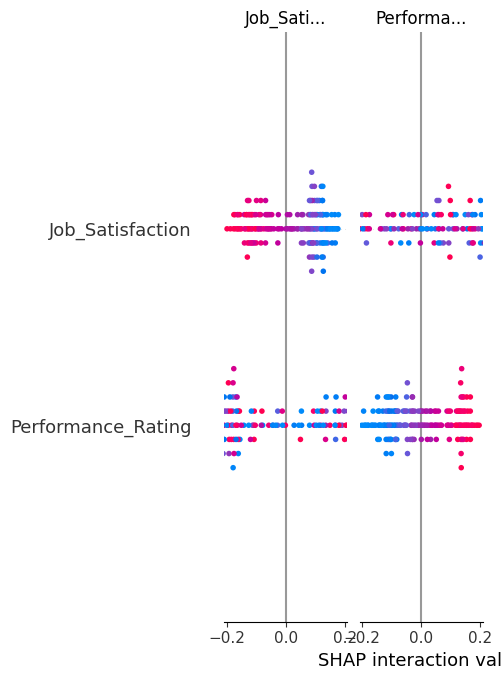

In [15]:

# ======================================================
# STEP 1K: Business Interpretation (Feature importance / Coefficients)
# ======================================================
def get_feature_names(preprocessor, numeric_features, categorical_features):
    feature_names = []
    feature_names.extend(list(numeric_features))
    if len(categorical_features) > 0:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        feature_names.extend(cat_names)
    return feature_names

trained_preprocess = tuned_clf.named_steps["preprocess"]
trained_model = tuned_clf.named_steps["model"]
feature_names = get_feature_names(trained_preprocess, numeric_features, categorical_features)

importance_df = None
if hasattr(trained_model, "feature_importances_"):
    importances = trained_model.feature_importances_
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance", ascending=False)
    print("Top drivers (Feature Importance):")
    display(importance_df.head(20))
elif hasattr(trained_model, "coef_"):
    coefs = trained_model.coef_.ravel()
    importance_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs}).sort_values("Coefficient", ascending=False)
    print("Top drivers (Logistic Coefficients - positive increases Leave probability):")
    display(importance_df.head(20))
else:
    print("Model does not expose feature importances/coefficients easily.")

# Optional SHAP (requires: !pip install shap)
try:
    import shap
    print("SHAP available. Building SHAP explanations (sampled)...")
    X_test_trans = trained_preprocess.transform(X_test)
    sample_size = min(200, X_test_trans.shape[0])
    idx = np.random.choice(X_test_trans.shape[0], size=sample_size, replace=False)
    X_sample = X_test_trans[idx]

    if "Forest" in trained_model.__class__.__name__ or "Tree" in trained_model.__class__.__name__ or "GradientBoosting" in trained_model.__class__.__name__:
        explainer = shap.TreeExplainer(trained_model)
    else:
        explainer = shap.LinearExplainer(trained_model, X_sample)

    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=True)
except Exception as e:
    print("SHAP not installed or failed; skipping SHAP. Error:", str(e)[:200])


In [16]:

# ======================================================
# STEP 1L: Risk Bands + Retention Action Logic
# ======================================================
def risk_band(p):
    if p < 0.30:
        return "Low"
    elif p < 0.60:
        return "Medium"
    else:
        return "High"

def action_recommendation(band):
    if band == "High":
        return "Manager 1:1, retention plan, compensation review, workload/WLB check"
    elif band == "Medium":
        return "Engagement survey follow-up, career path discussion, training plan"
    else:
        return "Normal monitoring and periodic check-ins"

test_output = X_test.copy()
test_output["Actual"] = y_test.values
test_output["Leave_Probability"] = final_eval["proba"]
test_output["Predicted"] = final_eval["pred"]

test_output["RiskBand"] = test_output["Leave_Probability"].apply(risk_band)
test_output["SuggestedAction"] = test_output["RiskBand"].apply(action_recommendation)

test_output["PredictedLabel"] = test_output["Predicted"].map({0: "Stay", 1: "Leave"})
test_output["ActualLabel"] = test_output["Actual"].map({0: "Stay", 1: "Leave"})

print("Predictions with risk bands generated.")
test_output.head()


Predictions with risk bands generated.


,Job_Satisfaction,Performance_Rating,Years_At_Company,Work_Life_Balance,Distance_From_Home,Monthly_Income,Education_Level,Age,Num_Companies_Worked,Employee_Role,...,Department,Annual_Bonus_Squared,Annual_Bonus_Training_Hours_Interaction,Actual,Leave_Probability,Predicted,RiskBand,SuggestedAction,PredictedLabel,ActualLabel
884,0.601944,0.063369,0.409857,0.722500,0.238739,0.943828,0.686783,0.287575,0.768999,0.083165,...,0.933456,0.950185,0.048042,0,0.281457,0,Low,Normal monitoring and periodic check-ins,Stay,Stay
382,0.001738,0.099908,0.363660,0.061197,0.382990,0.389567,0.920234,0.567072,0.706351,0.887199,...,0.285336,0.195478,0.000868,0,0.118815,0,Low,Normal monitoring and periodic check-ins,Stay,Stay
1190,0.140425,0.171648,0.918412,0.354705,0.216999,0.912069,0.970105,0.637770,0.388339,0.688386,...,0.368714,0.000242,0.002251,0,0.277834,0,Low,Normal monitoring and periodic check-ins,Stay,Stay
474,0.308528,0.942185,0.888265,0.860311,0.653000,0.344289,0.548849,0.815225,0.098610,0.801075,...,0.807564,0.001696,0.033620,1,0.780423,1,High,"Manager 1:1, retention plan, compensation revi...",Leave,Leave
1167,0.768613,0.608103,0.236034,0.694759,0.157859,0.878282,0.446326,0.475861,0.204148,0.615511,...,0.652345,0.970321,0.580293,0,0.543456,1,Medium,"Engagement survey follow-up, career path discu...",Leave,Stay


In [17]:

# ======================================================
# STEP 1M: Deployment Readiness + Monitoring Outputs
# ======================================================
import joblib

model_artifact_path = "employee_turnover_model_pipeline.joblib"
joblib.dump(tuned_clf, model_artifact_path)

monitoring_plan = pd.DataFrame([
    {
        "Monitoring Area": "Data Drift",
        "What to Monitor": "Distribution shifts in MonthlyIncome, JobSatisfaction, WorkLifeBalance, DistanceFromHome",
        "How Often": "Monthly",
        "Action if Drift": "Review feature distributions, retrain model with recent data"
    },
    {
        "Monitoring Area": "Performance",
        "What to Monitor": "Recall/Precision for Leave class, PR-AUC, ROC-AUC on recent labeled data",
        "How Often": "Monthly/Quarterly",
        "Action if Drift": "Retune threshold and/or retrain model"
    },
    {
        "Monitoring Area": "Business Outcome",
        "What to Monitor": "Retention interventions success rate for High Risk group",
        "How Often": "Quarterly",
        "Action if Drift": "Adjust intervention strategies and update action playbook"
    }
])

print("Model artifact saved:", model_artifact_path)
display(monitoring_plan)


Model artifact saved: employee_turnover_model_pipeline.joblib


,Monitoring Area,What to Monitor,How Often,Action if Drift
0,Data Drift,"Distribution shifts in MonthlyIncome, JobSatis...",Monthly,"Review feature distributions, retrain model wi..."
1,Performance,"Recall/Precision for Leave class, PR-AUC, ROC-...",Monthly/Quarterly,Retune threshold and/or retrain model
2,Business Outcome,Retention interventions success rate for High ...,Quarterly,Adjust intervention strategies and update acti...


In [18]:

# ======================================================
# STEP 2-5: Build Output Sheets (3 Tabs) + Exports
# ======================================================
sheet1 = test_output.copy()

csv_path = "Employee_Turnover_Predictions.csv"
sheet1.to_csv(csv_path, index=False)

risk_dist = sheet1["RiskBand"].value_counts(normalize=True).rename_axis("RiskBand").reset_index(name="Share")
risk_dist["Share"] = (risk_dist["Share"] * 100).round(2).astype(str) + "%"

outcomes_summary = pd.DataFrame([
    {"Outcome": "Model Output", "Details": "Probability of employee leaving + final Stay/Leave classification"},
    {"Outcome": "Risk Buckets", "Details": "Low (0–30%), Medium (30–60%), High (60–100%)"},
    {"Outcome": "How HR Uses It", "Details": "Early warning + targeted interventions + workplace policy improvements"},
    {"Outcome": "Selected Threshold", "Details": f"{best_threshold:.2f} (tuned for Leave recall + F1)"}
])

sheet2 = outcomes_summary
sheet2b = risk_dist

success_criteria = pd.DataFrame([
    {"Metric": "Confusion Matrix", "Value": str(final_eval["confusion_matrix"]), "Why it matters": "Shows FP/FN; FN (missed leavers) is costly"},
    {"Metric": "Recall (Leave class)", "Value": round(final_eval["recall_leave"], 4), "Why it matters": "Primary HR metric: catch more likely leavers"},
    {"Metric": "Precision (Leave class)", "Value": round(final_eval["precision_leave"], 4), "Why it matters": "Controls wasted interventions"},
    {"Metric": "F1 (Leave class)", "Value": round(final_eval["f1_leave"], 4), "Why it matters": "Balances precision & recall"},
    {"Metric": "ROC-AUC", "Value": round(final_eval["roc_auc"], 4) if final_eval["roc_auc"] == final_eval["roc_auc"] else None, "Why it matters": "Overall ranking quality"},
    {"Metric": "PR-AUC", "Value": round(final_eval["pr_auc"], 4) if final_eval["pr_auc"] == final_eval["pr_auc"] else None, "Why it matters": "More informative when Leave is rare"},
])

sheet3 = success_criteria

xlsx_path = "Employee_Turnover_Output.xlsx"
with ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    sheet1.to_excel(writer, index=False, sheet_name="1_Employee Turnover Prediction")
    sheet2.to_excel(writer, index=False, sheet_name="2_Expected Model Outcomes")
    sheet2b.to_excel(writer, index=False, sheet_name="2_Expected Model Outcomes", startrow=len(sheet2)+2)
    sheet3.to_excel(writer, index=False, sheet_name="3_Success Criteria")

print("Export complete:")
print(" -", csv_path)
print(" -", xlsx_path)


Export complete:
 - Employee_Turnover_Predictions.csv
 - Employee_Turnover_Output.xlsx


In [23]:
# ======================================================
# FINAL STEP: Export 3 CSV files + auto-download as ONE ZIP
# ======================================================
from google.colab import files
import zipfile
import os

# ------------------------------------------------------
# ✅ Make sure these 3 DataFrames already exist:
# 1) sheet1  -> Employee Turnover Prediction (row-level)
# 2) outcomes_summary (+ optional risk_dist) -> Expected Model Outcomes
# 3) success_criteria -> Success Criteria
# ------------------------------------------------------
# If you used my earlier export cell, these will exist as:
#   sheet1 = test_output.copy()
#   outcomes_summary = ...
#   risk_dist = ...
#   success_criteria = ...

# ---------------------------
# 1) Create 3 CSV files
# ---------------------------
csv_1 = "1_Employee Turnover Prediction.csv"
csv_2 = "2_Expected Model Outcomes.csv"
csv_3 = "3_Success Criteria.csv"

# Tab 1: Employee Turnover Prediction (everything)
sheet1.to_csv(csv_1, index=False)

# Tab 2: Expected Model Outcomes
# If you want ONLY outcomes_summary, keep as-is.
# If you want outcomes_summary + risk_dist together in ONE CSV, merge them cleanly:
try:
    # Combine as two sections in one CSV by stacking with blank rows
    blank = pd.DataFrame([[""] * max(outcomes_summary.shape[1], risk_dist.shape[1])])
    # Align columns before concatenation
    max_cols = max(outcomes_summary.shape[1], risk_dist.shape[1])
    out2 = outcomes_summary.copy()
    rd2  = risk_dist.copy()

    # Normalize columns count
    if out2.shape[1] < max_cols:
        for i in range(max_cols - out2.shape[1]):
            out2[f"extra_{i+1}"] = ""
    if rd2.shape[1] < max_cols:
        for i in range(max_cols - rd2.shape[1]):
            rd2[f"extra_{i+1}"] = ""

    combined_outcomes = pd.concat(
        [out2, pd.DataFrame([[""] * max_cols], columns=out2.columns), rd2],
        ignore_index=True
    )
    combined_outcomes.to_csv(csv_2, index=False)
except Exception:
    outcomes_summary.to_csv(csv_2, index=False)

# Tab 3: Success Criteria
success_criteria.to_csv(csv_3, index=False)

print("✅ 3 CSV files created:")
print(" -", csv_1)
print(" -", csv_2)
print(" -", csv_3)

# ---------------------------
# 2) Zip all 3 CSV files
# ---------------------------
zip_name = "Employee_Turnover_Outputs.zip"

with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    z.write(csv_1)
    z.write(csv_2)
    z.write(csv_3)

print("✅ ZIP created:", zip_name)

# ---------------------------
# 3) Download ZIP in browser
# ---------------------------
files.download(zip_name)

print("✅ Download triggered: Employee_Turnover_Outputs.zip")


✅ 3 CSV files created:
 - 1_Employee Turnover Prediction.csv
 - 2_Expected Model Outcomes.csv
 - 3_Success Criteria.csv
✅ ZIP created: Employee_Turnover_Outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download triggered: Employee_Turnover_Outputs.zip
